# ANOVAs for Transfer Learning
Use this notebook to format data for statistical analyses on transfer learning data for all subjects.

Nile Wilson, 2019.04.03

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
from scipy import stats
import scipy.io
import numpy as np
import pandas as pd
import datetime
import pickle
import glob
import csv
import mne
import os

# Set Your Variables
Define which subject's data you are going to use to simulate performance (be sure to make sure the subject_group and session_number are correct)

In [54]:
EEGdevice = 8
session_number = 1 #only do 1 for general model sim
model_type = 'experimental'
isSVM = False

### Function Definitions
Functions for working with the BCI data

In [20]:
def FindBCIFiles(subjID, run_number, session_number):
    """
    Returns the file names for the BCI run of choice
    """
    # Load latest model and its associated data
    BCI_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*' + subjID + '_BCI.easy')
    
    # Throw exception if model number is outside range of existing models
    if run_number-1 > len(BCI_files):
        raise ValueError('Please select a valid run number')
    
    filename_eeg = BCI_files[run_number-1]
    print('Selecting BCI EEG file: ' + filename_eeg)

    behavioral_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/BCI_' + subjID + '*.csv')
    filename_behavioral = behavioral_files[run_number-1]
    print('Selecting BCI behavioral file: ' + filename_behavioral)
    
    return filename_eeg, filename_behavioral

def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

def LoadBehavioralDataBCI(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    
    return behavioralData

def SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]

        # Number of trials is greater than number of total pulses sent
        # 999 when the task ends
        move_left_starts = np.where(EEGdata['STI 014'] == 1)[0]
        move_right_starts = np.where(EEGdata['STI 014'] == 2)[0]
        rest_starts = np.where(EEGdata['STI 014'] == 3)[0]
        rest_ends = np.where(EEGdata['STI 014'] == 4)[0]
        
        # If the number of rest_starts and rest_ends don't match, drop the extra one
        # there should, by default, only be 12 starts and 12 ends

        if len(rest_ends) > len(rest_starts):
            if rest_ends[0] < rest_starts[0]:
                rest_ends = rest_ends[1:]
        elif len(rest_ends) < len(rest_starts):
            if rest_ends[0] > rest_starts[0]:
                rest_starts = rest_starts[1:]
        
        move_starts = np.sort(np.concatenate((move_left_starts,move_right_starts),0))
        total_movements = len(move_starts)

        # exclude movements that occur without defined baseline (if you need to get rid of first rest)
        hasBaseline = list()
        for movement in range(0,len(move_starts)):
            hasBaseline.append(True in (rest_starts < move_starts[movement]))

        np.where(hasBaseline)
        move_starts = move_starts[np.where(hasBaseline)]

        # exclude the move lefts and move rights that were thrown out in move_starts
        for movement in range(0,total_movements):
            if hasBaseline[movement] is False:
                # for the left movements
                idx_left = np.where(move_left_starts == move_starts[movement])
                idx_left = np.asarray(idx_left)
                idx_right = np.where(move_right_starts == move_starts[movement])
                idx_right = np.asarray(idx_right)

                if idx_left.size > 0:
                    move_left_starts = np.delete(move_left_starts, idx_left)
                if idx_right.size > 0:
                    move_right_starts = np.delete(move_right_starts, idx_right)
                
        num_of_trials = len(rest_starts)
        num_of_movements = len(move_left_starts) + len(move_right_starts)
    
    return num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends

def EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]

    epochs = []
    epochs_norm = []

    for movement in range(0,len(move_starts)):
        # Data for this movement
        t_start = move_starts[movement] - np.round(2.00*fs)
        t_end = move_starts[movement] - np.round(0.250*fs)

        # Baseline
        restOfInt = np.max(np.where(rest_starts < move_starts[movement]))
        tb_start = rest_starts[restOfInt]
        tb_end = rest_ends[restOfInt]

        # Note, baseline is filtered before it is used in the live script
        baseline_pre_filt = np.asarray(EEGdata.loc[tb_start:tb_end][channels]) * 1.0
        baseline_filt = filter_data(baseline_pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        baseline = baseline_filt.T

        # Filter per epoch, like you would in real-time
        pre_filt = np.asarray(EEGdata.loc[t_start:t_end][channels]) * 1.0
        filtered = filter_data(pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        epoch = pd.DataFrame(filtered.T)
        epoch.columns = EEGdata.columns[0:8]

        # Store epoch
        tmp = (epoch - np.mean(baseline,0))/np.std(baseline,0)
        tmp = pd.DataFrame(tmp)
        tmp.columns = EEGdata.columns[0:8]

        epochs_norm.append(tmp)
        epochs.append(epoch)

    return epochs, epochs_norm

def OrganizeTrials(behavioralData, hasBaseline):
    """
    Organizes trials
    """
    
    # When the target is to the left
    trialL = np.where(behavioralData['target_x'] < 1000)
    
    # When target was to the right
    trialR = np.where(behavioralData['target_x'] > 1000)
    
    # Create a single list that includes which movement is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1

    trial_type = np.round(trial_type[0])
    
    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline)):
        if hasBaseline[movement] is False:
            trial_type = np.delete(trial_type, movement)
            
    return trial_type

def ExtractFeaturesBCI(epochs, num_of_movements, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for movement in range(0, num_of_movements):
            f, Pxx_den = signal.welch(signal.decimate(epochs[movement][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) >= 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) >= 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

def LoadModel_MI(subjID, run_number=0, session_number=1, adaptationType='CS'):
    """
    This function loads the most recent motor imagery classifier
    for this subject by default. Current run minus 1.
    
    You may also select which number model (from original to most recent)
    by using a value from 0 (original) to 4 (most recent)
    """
    runOfInt = run_number
    run_number = runOfInt - 1
    # Load latest model and its associated data
    if runOfInt == 1:
        models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
        models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
    else:
        if adaptationType == 'CS' or adaptationType == 'None':
            models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
            models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
        elif adaptationType == 'TL':
            models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_TL_*')
            models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_TL_*')
    
    # Throw exception if model number is outside range of existing models
    if run_number > len(models):
        raise ValueError('Please select a valid model number')
    if adaptationType == 'TL':
        run_number = run_number -1
    model_file = models[run_number] # load the most recent model
    print('Selecting model: ' + model_file)
    clf = pickle.load(open(model_file, 'rb'))

    models_data = models_data_list[run_number] # load the most recent model
    MI_data = np.load(models_data)
    X_loaded = MI_data['X_not_scaled']
    y_loaded = MI_data['y']
    
    return clf, X_loaded, y_loaded

def LoadGeneralModel_MI(subjID, isSVM):
    """
    This function loads the most recent motor imagery classifier
    for this subject by default. Current run minus 1.
    
    You may also select which number model (from original to most recent)
    by using a value from 0 (original) to 4 (most recent)
    """
    
    if isSVM is True:
        model_file = 'Models/GeneralModels/excluding_' + subjID + '/General_Model_MI_excluding_' + subjID + '_SVM.sav' # load the most recent model
        models_data = 'Models/GeneralModels/excluding_' + subjID + '/Data_for_General_MI_classifier_excluding_' + subjID + '_SVM.npz' # load the most recent model
    else:
        model_file = 'Models/GeneralModels/excluding_' + subjID + '/General_Model_MI_excluding_' + subjID + '.sav' # load the most recent model
        models_data = 'Models/GeneralModels/excluding_' + subjID + '/Data_for_General_MI_classifier_excluding_' + subjID + '.npz' # load the most recent model
    
    print('Selecting model: ' + model_file)
    clf = pickle.load(open(model_file, 'rb'))
    
    MI_data = np.load(models_data)
    X_loaded = MI_data['X_not_scaled']
    y_loaded = MI_data['y']
    
    return clf, X_loaded, y_loaded

def GetBehavioralTL(runOfInt):
    # When the target is to the left
    trialL = np.where(behavioralData_all[runOfInt]['target_x'] < 1000)
    movementL = np.where(behavioralData_all[runOfInt]['direction_moved'] == 'left')

    # When target was to the right
    trialR = np.where(behavioralData_all[runOfInt]['target_x'] > 1000)
    movementR = np.where(behavioralData_all[runOfInt]['direction_moved'] == 'right')

    # Create a single list that includes which movement is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData_all[runOfInt]['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1
    trial_type = np.round(trial_type[0])

    direction_moved = np.zeros([1,len(behavioralData_all[runOfInt]['score'])])
    direction_moved[0][movementL] = 0
    direction_moved[0][movementR] = 1
    direction_moved = np.round(direction_moved[0])

    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline_all[runOfInt])):
        if hasBaseline_all[runOfInt][movement] is False:
            trial_type = np.delete(trial_type, movement)
            direction_moved = np.delete(direction_moved, movement)
    
    actual = direction_moved
    TL = trial_type
    return actual, TL

# PART 1: Load all the data
Load in all the models and the associated data

Load Subjects

In [24]:
demographics_all = pd.read_csv('subject_demographics.csv')
generalSubjects = list(demographics_all['Subject ID'])
subject_group_all = np.asarray(demographics_all['Group Number'])
useBehavioral_all = np.asarray(demographics_all['useBehavioral'])
demographics_all.head()

,Subject ID,Group Number,Moving MI,Session 1,Session 2,Session 3,Handedness,Sex,Age,History of Neurological Disorders,Cap Size,useBehavioral
0,b12a46,1,No,0,8,15,R,M,21,No,M,No
1,41d8ff,1,No,0,5,12,R,F,21,No,M,No
2,1e8b34,1,No,0,3,14,R,M,29,No,L,No
3,ad11cf,1,No,0,7,12,R,F,20,Yes,M,No
4,b7ff16,2,No,0,19,21,R,F,20,No,M,No


# REMOVE THE REDEFINITION BELOW
Just have now to avoid running on subjects we don't have stuff on yet

In [36]:
# temporarily make subjects just a few group 1 subjects
generalSubjects = ['a1e6c0','e2cbc4']
subject_group_all = [1,1]
useBehavioral = ['Yes','Yes']

Get scores

In [32]:
orig_scores_all = dict.fromkeys(generalSubjects,[])
general_scores_all = dict.fromkeys(generalSubjects,[])
clf_orig_all = dict.fromkeys(generalSubjects,[])
clf_general_all = dict.fromkeys(generalSubjects,[])
behavioralData_all = dict.fromkeys(generalSubjects,[])
hasBaseline_all = dict.fromkeys(generalSubjects,[])
EEGdata_all = dict.fromkeys(generalSubjects,[])
subject_count = 0

for subjID in generalSubjects:
    
    BCI_files = glob.glob('SaveData/' + subjID + '/Session1/*' + subjID + '_BCI.easy')
    num_of_runs = len(BCI_files)

    subject_group = subject_group_all[subject_count]
    counter = 1 # keeps track of all runs (start from 1->15)
    
    orig_scores = list()
    general_scores = list()
    actual_scores = list()
    X_orig_all = dict()
    y_orig_all = dict()
    X_general_all = dict()
    y_general_all = dict()
    clf_orig_one_subject = dict()
    clf_general_one_subject = dict()
    behavioralData_one_subject = dict()
    hasBaseline_one_subject = dict()
    EEGdata_one_subject = dict()
    
    for runOfInt in range(1, num_of_runs+1):
        # Find BCI file names
        filename_eeg, filename_behavioral = FindBCIFiles(subjID, runOfInt, session_number)

        # Load EEG data
        EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)
        EEGdata_all[counter] = EEGdata

        # Load behavioral data
        behavioralData = LoadBehavioralDataBCI(filename_behavioral)
        behavioralData_all[counter] = behavioralData

        # Sync up trigger pulses
        num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends = SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData)
        hasBaseline_all[counter] = hasBaseline

        # Epoch the data
        epochs, epochs_norm = EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends)

        # Organize trial types
        trial_type = OrganizeTrials(behavioralData, hasBaseline)

        # Get signal features
        alpha_power, beta_power = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)
        motor_features = [alpha_power['C3'], beta_power['C3'], alpha_power['C4'], beta_power['C4']]
        motor_features = np.transpose(motor_features)

        # Load a specific model (0 loads initial model trained on screening)
        # If using run_number, it will load the model created just prior to
        # this BCI run (simulated or created during the session)
        if subject_group == 1:
            clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, 1, session_number, 'None')
        elif subject_group == 2:
            clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, runOfInt, session_number, 'CS')

        # Get the original score
        X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
        y = trial_type
        orig_score = clf_orig.score(X, y)*100
        X_orig_all[counter] = X
        y_orig_all[counter] = y

        # Get the simulated score (using the general model)
        clf_general, X_loaded, y_loaded = LoadGeneralModel_MI(subjID, isSVM)

        X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
        y = trial_type
        general_score = clf_general.score(X, y)*100
        X_general_all[counter] = X
        y_general_all[counter] = y

        # Store values
        orig_scores.append(orig_score)
        general_scores.append(general_score)
        clf_orig_one_subject[counter] = clf_orig
        clf_general_one_subject[counter] = clf_general
        
    orig_scores_all[subjID] = orig_scores
    general_scores_all[subjID] = general_scores
    clf_orig_all[subjID] = clf_orig_one_subject
    clf_general_all[subjID] = clf_general_one_subject
    behavioralData_all[subjID] = behavioralData_one_subject
    hasBaseline_all[subjID] = hasBaseline_one_subject
    EEGdata_all[subjID] = EEGdata_one_subject
    
    print('----------------------------------------------------')
    print('Done storing values for ' + subjID)
    print('----------------------------------------------------')
    subject_count += 1

Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319133926_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319134508_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319135043_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319135618_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319140149_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav
----------------------------------------------------
Done storing values for a1e6c0
----------------------------------------------------
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301133119_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/Session1\e2cbc4_MI_classifier_2019-03-01-13-30-52.sav
Selecting model: Models/GeneralModels/excluding_e2cbc4/General_Model_MI_excluding_e2cbc4.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301133623_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/Session1\e2cbc4_MI_classifier_2019-03-01-13-30-52.sav
Selecting model: Models/GeneralModels/excluding_e2cbc4/General_Model_MI_excluding_e2cbc4.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301134108_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/Session1\e2cbc4_MI_classifier_2019-03-01-13-30-52.sav
Selecting model: Models/GeneralModels/excluding_e2cbc4/General_Model_MI_excluding_e2cbc4.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301134618_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/Session1\e2cbc4_MI_classifier_2019-03-01-13-30-52.sav
Selecting model: Models/GeneralModels/excluding_e2cbc4/General_Model_MI_excluding_e2cbc4.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301135102_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/Session1\e2cbc4_MI_classifier_2019-03-01-13-30-52.sav
Selecting model: Models/GeneralModels/excluding_e2cbc4/General_Model_MI_excluding_e2cbc4.sav
----------------------------------------------------
Done storing values for e2cbc4
----------------------------------------------------


## Organize the data

Store subject performance in one easy variable, where subjects with data collected in the first phase (where there was a bug in the experimental code) use simulated performance, and subjects with data collected in the second phase use actual performance.

In [40]:
subject_count = 0
actual_scores = dict()

for subjID in generalSubjects:
    subject_count = generalSubjects.index(subjID)
    actual_scores_tmp = list()
    
    # Use true behavioral data for collection 2 subjects
    # Use 1,5+1 for when useBehavioral is True because the actual run numbers save
    # Use 0, 5 for when useBehavioral is False because runs are just saved through append
    if useBehavioral[subject_count] == True:
        for runOfInt in range(1,5+1):
            actual, TL = GetBehavioralTL(runOfInt, behavioralData_all[subjID], hasBaseline_all[subjID])
            correct_all = len(np.where(TL==actual)[0])/len(TL)*100
            actual_scores_tmp.append(correct_all)
        actual_scores[subjID] = actual_scores_tmp
    else:
        # Use simulated behavior for collection 1 subjects
        for runOfInt in range(0,5):
            actual_scores_tmp.append(orig_scores_all[subjID][runOfInt])
        actual_scores[subjID] = actual_scores_tmp

Store all relevant data for ANOVA in convenient pandas dataframe

In [41]:
all_scores = pd.DataFrame()

In [45]:
# Split by group 1 or group 2
actual_scores_no_adapt_flat = list()
actual_scores_co_adapt_flat = list()
general_scores_flat = list()

for i in range(0,len(actual_scores)):
    for j in range(0,len(actual_scores[generalSubjects[i]])):
        if subject_group_all[i] == 1:
            actual_scores_no_adapt_flat.append(actual_scores[generalSubjects[i]][j])
        else:
            actual_scores_co_adapt_flat.append(actual_scores[generalSubjects[i]][j])
        general_scores_flat.append(general_scores_all[generalSubjects[i]][j])

In [46]:
len(actual_scores_no_adapt_flat)

10

In [48]:
len(general_scores_flat)

10

In [49]:
all_scores['original'] = pd.Series(actual_scores_no_adapt_flat)
all_scores['general model'] = pd.Series(general_scores_flat)

In [50]:
all_scores.head()

,original,general model
0,46.017699,52.212389
1,64.761905,50.476190
2,43.925234,47.663551
3,56.074766,50.467290
4,50.000000,46.153846


## Save the data
Save the organized data for easy access later

In [55]:
time_to_save = datetime.datetime.now().isoformat()
time_to_save = time_to_save.replace('T','-')
time_to_save = time_to_save.replace(':','-')
    
filepath = time_to_save[:19] + '_all_scores_general_model.sav'
np.savez_compressed(filepath, subjID_all=generalSubjects, all_scores=all_scores,
                    actual_scores_no_adapt_flat=actual_scores_no_adapt_flat,
                    actual_scores_co_adapt_flat=actual_scores_co_adapt_flat,
                    general_scores_flat=general_scores_flat,
                    subject_group_all=subject_group_all, model_type=model_type, useBehavioral=useBehavioral, EEGdevice=EEGdevice)

## Run some ANOVAs
Let's start out with a simple 1-way ANOVA comparing the different adaptation schemes. Refering to this https://vknight.org/unpeudemath/python/2016/08/13/Analysis-of-variance-with-different-sized-sample.html

### 1-Way ANOVA
ANOVA comparing the difference in performance between the following adaptation schemes
1. No adaptation
2. Co-adaptation
3. Simulated True Label Adaptation

In [43]:
#len(all_scores['no adaptation'].dropna(axis=0))

In [56]:
data = [actual_scores_no_adapt_flat,general_scores_flat,]
f_val, p_val = stats.f_oneway(*data)
p_val

0.7984172387648416

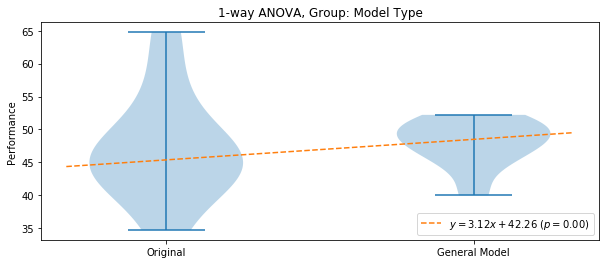

In [58]:
# Fit line to median of distributions
x = range(1, len(data) + 1)
y = [np.median(sample) for sample in data]
slope, intercept, r_val, p_val_plot, slope_std_error = stats.linregress(x, y)

def line(x):
    """The regression line"""
    return slope * x + intercept

plt.figure(figsize=(10,4))
plt.violinplot(data);
x1, x2 = plt.xlim()
plt.plot((x1, x2), (line(x1), line(x2)), '--',
         label="$y = {0:.2f}x + {1:.2f}$ ($p={2:.2f}$)".format(slope,
                                                               intercept,
                                                               p_val_plot))
plt.ylabel('Performance')
plt.xticks([1,2], ['Original','General Model'])
plt.title('1-way ANOVA, Group: Model Type')
plt.legend(loc=4);

In [59]:
print('F(?,?) = ' + str(f_val) + ', p = ' + str(p_val))

F(?,?) = 0.06718793018706647, p = 0.7984172387648416


### 2-Way ANOVA
ANOVA comparing the difference in performance between the following adaptation schemes
1. Adaptation Scheme (No adaptation, Co-adaptation, Simulated True Label Adaptation)
2. Session Number (1, 2, or 3)
3. Run Number (1, 2, 3, 4, or 5)
4. Subject ID
5. Handedness
6. Age

In [62]:
g1 = list() # model type
g2 = list() # session number
g3 = list() # run number
g4 = list() # subjID
g5 = list() # handedness
g6 = list() # age

# Split by group 1 or group 2
all_scores_flat = list()
actual_scores_no_adapt_flat = list()
actual_scores_co_adapt_flat = list()
general_scores_flat = list()
subjID_all = generalSubjects

for i in range(0,len(actual_scores)):
    for j in range(0,5):
        if subject_group_all[i] == 1:
            all_scores_flat.append(actual_scores[subjID_all[i]][j])
            actual_scores_no_adapt_flat.append(actual_scores[subjID_all[i]][j])
            g1.append('no adaptation')
            g4.append(subjID_all[i])
            
            if j < 5:
                g2.append('Session 1')
            if j >= 5:
                if j < 10:
                    g2.append('Session 2')
                if j >= 10:
                    g2.append('Session 3')
            if j in [0,5,10]:
                g3.append('Run 1')
            if j in [1,6,11]:
                g3.append('Run 2')
            if j in [2,7,12]:
                g3.append('Run 3')
            if j in [3,8,13]:
                g3.append('Run 4')
            if j in [4,9,13]:
                g3.append('Run 5')
                    
        else:
            all_scores_flat.append(actual_scores[subjID_all[i]][j])
            actual_scores_co_adapt_flat.append(actual_scores[subjID_all[i]][j])
            g1.append('co-adaptation')
            g4.append(subjID_all[i])
            if j < 5:
                g2.append('Session 1')
            if j >= 5:
                if j < 10:
                    g2.append('Session 2')
                if j >= 10:
                    g2.append('Session 3')
            if j in [0,5,10]:
                g3.append('Run 1')
            if j in [1,6,11]:
                g3.append('Run 2')
            if j in [2,7,12]:
                g3.append('Run 3')
            if j in [3,8,13]:
                g3.append('Run 4')
            if j in [4,9,13]:
                g3.append('Run 5')

        all_scores_flat.append(general_scores_all[subjID_all[i]][j])
        general_scores_flat.append(general_scores_all[subjID_all[i]][j])
        g1.append('simulated TL adaptation')
        g4.append(subjID_all[i])

        if j < 5:
            g2.append('Session 1')
        if j >= 5:
            if j < 10:
                g2.append('Session 2')
            if j >= 10:
                g2.append('Session 3')
        if j in [0,5,10]:
            g3.append('Run 1')
        if j in [1,6,11]:
            g3.append('Run 2')
        if j in [2,7,12]:
            g3.append('Run 3')
        if j in [3,8,13]:
            g3.append('Run 4')
        if j in [4,9,13]:
            g3.append('Run 5')

Refer to https://plot.ly/python/anova/

Might be easier to export this as a .mat file and then do the 2-way ANOVA in MATLAB...

In [63]:
# Flatten all to one long vector and then save group names
all_scores_export = all_scores_flat

In [64]:
len(all_scores_export)

20

In [65]:
len(g1)

20

In [66]:
len(g2)

20

In [67]:
len(g3)

20

In [68]:
len(g4)

20

Note that we have more than 15 x 9 (285) scores because we are including the simulated TL stuff as well

In [69]:
# Save as .mat
time_to_save = datetime.datetime.now().isoformat()
time_to_save = time_to_save.replace('T','-')
time_to_save = time_to_save.replace(':','-')
    
filepath = time_to_save[:19] + '_all_scores_for_2-way_ANOVA_sessions_general_model.sav'
scipy.io.savemat(filepath, mdict={'all_scores_export': all_scores_export, 'ModelType':g1,
                                  'SessionNumber':g2, 'RunNumber':g3, 'Subject':g4,
                                 'Handedness':g5, 'Age':g6})

C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '
